In [1]:
!pip install lingam

In [24]:
#German
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import train_test_split

from csse import CSSE
from prepare_dataset import *

import pickle

import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import print_causal_directions, print_dagc, make_dot

from tqdm import tqdm
import random as rnd

from IPython.display import display

import warnings

warnings.filterwarnings('ignore')

In [25]:
# # Read Dataset German
# x_train = pd.read_csv("data/algrec_german/X_train_short.csv").rename(columns=map_columns)
# x_test = pd.read_csv("data/algrec_german/X_test_short.csv").rename(columns=map_columns)
# y_train = pd.read_csv("data/algrec_german/y_train_short.csv").rename(columns={'Unnamed: 0': 'index'})
# y_test = pd.read_csv("data/algrec_german/y_test_short.csv").rename(columns={'Unnamed: 0': 'index'})

# x_train = x_train.set_index('index')
# x_test = x_test.set_index('index')
# y_train = y_train.set_index('index')
# y_test = y_test.set_index('index')

# dfx_full = pd.concat([x_train, x_test])
# dfy_full = pd.concat([y_train, y_test])

# model = RandomForestClassifier()  
# model.fit(x_train, y_train)

# index_samples = [747, 349, 646, 76, 890]

# x_test_sample = x_test.loc[index_samples]
# y_test_sample = y_test.loc[index_samples]


# p = model.predict(x_test)

# print(classification_report(y_test, p))

# K = 5 #Number of counterfactual explanations to be obtained

# explainerCSSE = CSSE(dfx_full, model, K = K, num_gen = 10)

In [26]:
# Read Dataset German
df_main = prepare_german_dataset("german_credit.csv", "data/")

#Get the input features
columns = df_main.columns
class_name = 'default' # default = 0 = "Good class" / default = 1 = "Bad class" 
columns_tmp = list(columns)
columns_tmp.remove(class_name)

x_train, x_test, y_train, y_test = train_test_split(df_main[columns_tmp], df_main[class_name], test_size=0.1)

dfx_full = pd.concat([x_train, x_test])
dfy_full = pd.concat([y_train, y_test])

model = RandomForestClassifier(n_estimators = 120, n_jobs=-1, random_state=0)  
model.fit(x_train, y_train)

p = model.predict(x_test)

print(classification_report(y_test, p))

K = 5 #Number of counterfactual explanations to be obtained

explainerCSSE = CSSE(df_main[columns_tmp], model, K = K, num_gen = 3)

              precision    recall  f1-score   support

           0       0.78      0.89      0.83        71
           1       0.58      0.38      0.46        29

    accuracy                           0.74       100
   macro avg       0.68      0.63      0.64       100
weighted avg       0.72      0.74      0.72       100



In [27]:
# model_lingam = lingam.DirectLiNGAM()

# result_lingam_bt = model_lingam.bootstrap(dfx_full, n_sampling=100)

# causal_effects = result_lingam_bt.get_total_causal_effects(min_causal_effect=0.01)

# df_causal_effects = pd.DataFrame(causal_effects)
# labels = [f'{i}' for i in dfx_full.columns]

# df_causal_effects['from'] = df_causal_effects['from'].apply(lambda x : labels[x])
# df_causal_effects['to'] = df_causal_effects['to'].apply(lambda x : labels[x])

# causal_order = [labels[x] for x in model_lingam.causal_order_]

In [28]:
model_lingam = lingam.DirectLiNGAM()
model_lingam.fit(dfx_full)

In [29]:
labels = [f'{i}' for i in dfx_full.columns]
causal_order = [labels[x] for x in model_lingam.causal_order_]
causal_order

['foreign_worker',
 'other_debtors',
 'people_under_maintenance',
 'savings',
 'other_installment_plans',
 'telephone',
 'credit_amount',
 'housing',
 'credit_history',
 'credits_this_2',
 'property',
 'personal_status_sex',
 'job',
 'account_check_status',
 'purpose',
 'present_res_since',
 'installment_as_income_perc',
 'present_emp_since',
 'age',
 'duration_in_month']

In [30]:
matrix = model_lingam.adjacency_matrix_
from_list = []
to_list = []
effect_list = []

# Iteração sobre a matriz para extrair os valores e suas posições
for i in range(len(matrix)):
    for j in range(len(matrix[i])):
        if matrix[i][j] != 0:
            from_list.append(j)
            to_list.append(i)
            effect_list.append(matrix[i][j])

# Criando o DataFrame
df_causal_effects = pd.DataFrame({'from': from_list, 'to': to_list, 'effect': effect_list})
labels = [f'{i}' for i in dfx_full.columns]
df_causal_effects['from'] = df_causal_effects['from'].apply(lambda x : labels[x])
df_causal_effects['to'] = df_causal_effects['to'].apply(lambda x : labels[x])
df_causal_effects

,from,to,effect
0,credit_history,account_check_status,0.209173
1,savings,account_check_status,0.163528
2,other_debtors,account_check_status,-0.260167
3,purpose,duration_in_month,0.397288
4,credit_amount,duration_in_month,0.002850
5,installment_as_income_perc,duration_in_month,2.621292
6,property,duration_in_month,0.956366
7,age,duration_in_month,-0.080344
8,foreign_worker,duration_in_month,-3.902877
9,credit_history,purpose,-0.202136


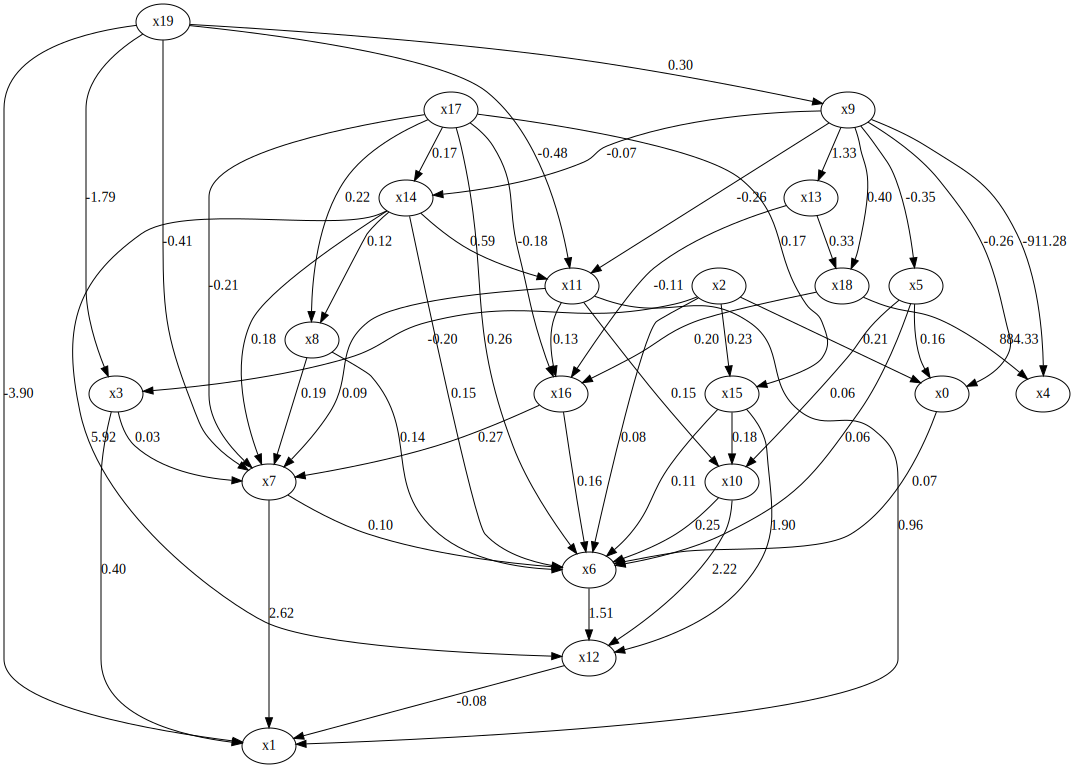

In [31]:
make_dot(model_lingam.adjacency_matrix_)

In [34]:
def apply_causality(df):
    df_apply_causal = pd.DataFrame(columns = df.columns)
    original = df.iloc[0]
    df_apply_causal.loc[0] = original
    for index, df_row in df.iloc[1:].iterrows():
        causal_ind = df_row.copy()
        for column in causal_order:
            value_diff = causal_ind[column] - original[column]
            if value_diff != 0:
                tmp_effects = df_causal_effects[df_causal_effects['from'] == column]
                for index, row in tmp_effects.iterrows():
#                     prob = rnd.random()
#                     if row['probability'] <= prob:
                    causal_ind[row['to']] = causal_ind[row['to']] + (value_diff * row['effect'])
        df_apply_causal.loc[len(df_apply_causal)] = causal_ind
    return df_apply_causal
    
def euclidean_distance(series1, series2):
    # Verificando se as séries têm o mesmo comprimento
    if len(series1) != len(series2):
        raise ValueError("As séries devem ter o mesmo comprimento.")
    
    # Calculando a diferença quadrática entre os elementos das séries
    squared_diff = (series1 - series2) ** 2
    
    # Calculando a soma das diferenças quadráticas
    sum_squared_diff = np.sum(squared_diff)
    
    # Calculando a raiz quadrada da soma
    euclidean_dist = np.sqrt(sum_squared_diff)
    
    return euclidean_dist

def get_contrafac_df_causal(solution_list_causal):
    lista_solution_causal = [[t.column for t in sublist] for sublist in solution_list_causal]

    # Inicializa uma lista para armazenar os resultados
    resultados = []

    # Loop sobre os valores na lista
    for lista_valores in lista_solution_causal:
        if len(lista_valores) > 1:
            for v1 in lista_valores:
                for v2 in lista_valores:
                    if v1 != v2:
                        # Cria uma condição para cada par de valores diferentes na lista
                        condicao = (df_causal_effects['to'].isin([v1, v2])) & (df_causal_effects['from'].isin([v1, v2]))
                        # Realiza a busca no DataFrame usando a condição e armazena os resultados
                        resultados.append(df_causal_effects[condicao])

    # Concatena os resultados em um único DataFrame
    if resultados:
        resultado_final = pd.concat(resultados)
        resultado_final = resultado_final.drop_duplicates()
    else:
        resultado_final = pd.DataFrame(columns = df_causal_effects.columns)
        
    return resultado_final

def analyse_contrafac(contrafac, df, original_ind):
    columns = [x.column for x in contrafac]
    condicao = (df['to'].isin(columns)) & (df['from'].isin(columns))
    ind = original_ind[columns]
    return [contrafac, df[condicao], ind]

def verificar_condicoes(row):
    if (row['from'] == 'mais' and row['to'] == 'mais' and row['effect'] > 0):
        return True
    elif row['from'] == 'menos' and row['to'] == 'menos' and row['effect'] > 0:
        return True
    elif row['from'] == 'mais' and row['to'] == 'menos' and row['effect'] < 0:
        return True
    elif row['from'] == 'menos' and row['to'] == 'mais' and row['effect'] < 0:
        return True
    else:
        return False

In [35]:
def get_causal_explain(X):
    original_ind = x_test.iloc[X].copy() #Original instance
    #self.ind_cur_class = ind_cur_class #Index in the shap corresponds to the original instance class
    explainerCSSE.current_class = p[X] #Original instance class
    explainerCSSE.original_ind = original_ind

    ind_cur_class = explainerCSSE.getBadClass()

    #Gets the valid values range of each feature
    features_range = []
    features_range = explainerCSSE.getFeaturesRange()

    #The DataFrame df will have the current population
    df = pd.DataFrame(columns=explainerCSSE.input_dataset.columns)

    #Generates the initial population with popinitial mutants        
    explainerCSSE.getPopInicial(df, features_range)
    df_causal = df.copy()
    dict_dfs = {}

    # for g in tqdm(range(explainerCSSE.num_gen), desc= "Processing..."):
    for g in tqdm(range(10), desc= "Processing..."):

        #To use on the parents of each generation
        parents = pd.DataFrame(columns=explainerCSSE.input_dataset.columns)

        #Copy parents to the next generation
        parents = df_causal.copy()
        dict_dfs[g] = {}

        parents_causal = apply_causality(parents)
        dict_dfs[g]['causal_parents'] = parents_causal
        #df will contain the new population
        df_causal = pd.DataFrame(columns=explainerCSSE.input_dataset.columns)
        evaluation_causal = []

        #Assessing generation counterfactuals
        explainerCSSE.fitness(dict_dfs[g]['causal_parents'], evaluation_causal, ind_cur_class)

        #The original individual will always be in the 0 position of the df - So that it is normalized too (it will be used later in the distance function)
        df_causal.loc[0] = original_ind.copy()

        #Copies to the next generation the per_elit best individuals
        explainerCSSE.elitism(evaluation_causal, df_causal, parents_causal)
        number_cross_repetitions = 0
        while len(df_causal) < explainerCSSE.pop_size + 1: #+1, as the 1st position is used to store the reference individual
            number_cross_repetitions_causal = explainerCSSE.crossover(df_causal, parents_causal, evaluation_causal, number_cross_repetitions)

            mutation_op = rnd.random()
            if mutation_op <= explainerCSSE.mutation_proba:
                explainerCSSE.mutation(df_causal, len(df_causal) - 1, features_range)


    evaluation = []
    evaluation_causal = []

    #Evaluating the latest generation
    explainerCSSE.fitness(df_causal, evaluation_causal, ind_cur_class)

    #Order the last generation by distance to the original instance     
    evaluation_causal.sort(key=lambda individual: individual.aval_norm) 

    #Getting the counterfactual CAUSAL set
    contrafactual_set_causal, solution_list_causal = explainerCSSE.getContrafactual(df_causal, evaluation_causal) 

    dict_dfs['contrafactual_set_causal'] = contrafactual_set_causal
    dict_dfs['solution_list_causal'] = solution_list_causal
    df_contrafac_causal = get_contrafac_df_causal(solution_list_causal)
    return [solution_list_causal, df_contrafac_causal, original_ind]

In [36]:
def run(original_row):
    response_list = get_causal_explain(original_row)
    list_analyse = []
    for contrafac_causal in response_list[0]:
        list_analyse.append(analyse_contrafac(contrafac_causal, response_list[1], response_list[2]))
    return list_analyse

In [37]:
%time
global_quant_changes = 0
global_quant_causal_changes = 0
global_quant_causal_rules = 0
global_quant_zeros_causal = 0
global_quant_full_causal = 0
global_quant_causal_contrafac = 0
global_quant_maioria_causal_satisfeita = 0
global_quant_contrafac_unico = 0

quant_original_instance = 10
for x in range(quant_original_instance):
    print(f"\nrun {x}")
    runs = run(x)
    for content in runs:
        controle = {}
        causal = content[0]
        df = content[1]
        ori = content[2]
        
        num_changes = len(causal)
        global_quant_changes += num_changes
        
        num_causal_rules = len(df)
        global_quant_causal_rules += num_causal_rules
        
        for attr in causal:
            key = attr.column
            if attr.value > ori[key]:
                controle[key] = 'mais'
            else:
                controle[key] = 'menos'

        df_temp = df.copy()
        df_temp['from'] = df['from'].map(controle)
        df_temp['to'] = df['to'].map(controle)
        df_temp['causal'] = df_temp.apply(verificar_condicoes, axis = 1)
        
        causal_finds = df_temp['causal'].sum()
        global_quant_causal_changes += causal_finds
        
        print(f'causal = \n{causal}\n')
        print(f'original = \n{ori}\n')
        print(f'df_temp = \n{display(df_temp)}\n')
        print('---------------------------------------------------\n')
        
        if len(df_temp) > 0:
            if causal_finds > 0:
                global_quant_causal_contrafac += 1
            else:
                print(f'nenhuma relaçao causal satisfeita')
                global_quant_zeros_causal += 1
                display(df_temp)
                print(f"original = {ori}")
                print(f"causal = {causal}")

            if causal_finds == num_causal_rules:
                global_quant_full_causal += 1
                if causal_finds > 2:
                    print(f'todas > 2 relaçoes causais satisfeitas')
                    display(df_temp)
                    print(f"original = {ori}")
                    print(f"causal = {causal}")
                elif causal_finds == 1:
                    print(f'todas = 1 relaçoes causais satisfeitas')
            
            if causal_finds >= (len(df_temp)/2):
                global_quant_maioria_causal_satisfeita += 1
        else:
#             if len(causal) > 0:
            global_quant_contrafac_unico += 1

                
quant_contrafac = quant_original_instance*K

print()
print(f"quantas instancias contrafactuais encontradas = {quant_contrafac}")
print(f"quantidade de mudanças totais = {global_quant_changes}")

print(f"quantas instancias tiveram pelo menos uma relação causal satisfeita = {global_quant_causal_contrafac}/{quant_contrafac}")

print(f"quantas relações causais foram encontradas = {global_quant_causal_rules}")

print(f"quantas relações causais foram satisfeitas = {global_quant_causal_changes}/{global_quant_causal_rules}")

print(f"quantas instâncias não tiveram nenhuma relação causal satisfeita = {global_quant_zeros_causal}/{quant_contrafac}")
print(f"quantas instâncias tiveram TODAS as relaçoes causais satisfeitas = {global_quant_full_causal}/{global_quant_causal_contrafac}")

print(f'quantas instancias causais teveram a maioria das relacoes causais satisfeitas = {global_quant_maioria_causal_satisfeita}/{quant_contrafac}')
print(f'quantas instancias tiveram um unico atributo modificado = {global_quant_contrafac_unico}/{quant_contrafac}')

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.11 µs

run 0


Processing...: 100%|██████████| 10/10 [00:28<00:00,  2.86s/it]


causal = 
[('duration_in_month', 53.41439373789759), ('present_emp_since', 2.1283001669510453), ('installment_as_income_perc', 3.1743536404368085), ('age', 8.961486153003115), ('job', 3.347172852175826)]

original = 
duration_in_month             24
present_emp_since              3
installment_as_income_perc     4
age                           37
job                            3
Name: 546, dtype: int64



,from,to,effect,causal
5,menos,mais,2.621292,False
7,menos,mais,-0.080344,True
17,menos,menos,0.098358,True
42,menos,menos,1.512757,True
22,mais,menos,0.161783,False
29,mais,menos,0.266864,False


df_temp = 
None

---------------------------------------------------

causal = 
[('account_check_status', 2.0), ('duration_in_month', 24.08914738467129), ('present_emp_since', 1.963913742888064), ('installment_as_income_perc', 3.3727637215081625), ('age', -20.367934539233733)]

original = 
account_check_status           4
duration_in_month             24
present_emp_since              3
installment_as_income_perc     4
age                           37
Name: 546, dtype: int64



,from,to,effect,causal
5,menos,mais,2.621292,False
7,menos,mais,-0.080344,True
17,menos,menos,0.098358,True
42,menos,menos,1.512757,True
14,menos,menos,0.071657,True


df_temp = 
None

---------------------------------------------------

causal = 
[('duration_in_month', 59.01207091348473), ('present_emp_since', 1.4892684652387733), ('installment_as_income_perc', 3.6863818607540813), ('present_res_since', 2.187494897617925), ('age', -20.367934539233733)]

original = 
duration_in_month             24
present_emp_since              3
installment_as_income_perc     4
present_res_since              4
age                           37
Name: 546, dtype: int64



,from,to,effect,causal
5,menos,mais,2.621292,False
7,menos,mais,-0.080344,True
17,menos,menos,0.098358,True
42,menos,menos,1.512757,True
19,menos,menos,0.245866,True
43,menos,menos,2.216975,True


df_temp = 
None

---------------------------------------------------

causal = 
[('account_check_status', 1.3270567989418203), ('duration_in_month', 68.61350776111728), ('present_emp_since', 1.4677217972641365), ('age', 26.85890547692049)]

original = 
account_check_status     4
duration_in_month       24
present_emp_since        3
age                     37
Name: 546, dtype: int64



,from,to,effect,causal
7,menos,mais,-0.080344,True
42,menos,menos,1.512757,True
14,menos,menos,0.071657,True


df_temp = 
None

---------------------------------------------------

todas > 2 relaçoes causais satisfeitas


,from,to,effect,causal
7,menos,mais,-0.080344,True
42,menos,menos,1.512757,True
14,menos,menos,0.071657,True


original = account_check_status     4
duration_in_month       24
present_emp_since        3
age                     37
Name: 546, dtype: int64
causal = [('account_check_status', 1.3270567989418203), ('duration_in_month', 68.61350776111728), ('present_emp_since', 1.4677217972641365), ('age', 26.85890547692049)]
causal = 
[('account_check_status', 1.4905851984127305), ('duration_in_month', 97.07916093746299), ('credit_amount', 5009.280676980847), ('installment_as_income_perc', 0.36388065388375035), ('personal_status_sex', 1.6666924366708604), ('present_res_since', 0.8128685028923824), ('property', -1.3466798090545649), ('age', -70.61677505170054), ('housing', 1.0741525535469032), ('job', 0.5299612555140663)]

original = 
account_check_status             4
duration_in_month               24
credit_amount                 2022
installment_as_income_perc       4
personal_status_sex              2
present_res_since                4
property                         3
age                       

,from,to,effect,causal
5,menos,mais,2.621292,False
7,menos,mais,-0.080344,True
29,menos,menos,0.266864,True
43,menos,menos,2.216975,True
4,mais,mais,0.002850,True
6,menos,mais,0.956366,False
25,mais,menos,-0.000140,True
38,mais,menos,0.000098,False
47,mais,menos,0.000025,False
52,mais,menos,0.000044,False


df_temp = 
None

---------------------------------------------------


run 1


Processing...: 100%|██████████| 10/10 [00:22<00:00,  2.23s/it]


causal = 
[('duration_in_month', 45.604805812054046)]

original = 
duration_in_month    12
Name: 759, dtype: int64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('duration_in_month', 45.18939444641381), ('age', 22.216798888721293)]

original = 
duration_in_month    12
age                  35
Name: 759, dtype: int64



,from,to,effect,causal
7,menos,mais,-0.080344,True


df_temp = 
None

---------------------------------------------------

todas = 1 relaçoes causais satisfeitas
causal = 
[('duration_in_month', 41.961197260348044), ('present_emp_since', 3.714322943880264), ('installment_as_income_perc', 2.3988143800777477), ('age', 28.243480582179686)]

original = 
duration_in_month             12
present_emp_since              5
installment_as_income_perc     4
age                           35
Name: 759, dtype: int64



,from,to,effect,causal
7,menos,mais,-0.080344,True
5,menos,mais,2.621292,False
17,menos,menos,0.098358,True
42,menos,menos,1.512757,True


df_temp = 
None

---------------------------------------------------

causal = 
[('account_check_status', 0.7938066093508377), ('duration_in_month', 39.77545597118424), ('purpose', -1.7870939304255342), ('credit_amount', 710.0610824216155), ('savings', 0.7925494922214327), ('present_emp_since', 4.714614980127823), ('installment_as_income_perc', 3.303751707093023), ('personal_status_sex', 2.9923445002215576), ('other_debtors', 1.298476046139596), ('present_res_since', 2.7875081398774935), ('property', 1.322120540006357), ('age', 30.574976085128082), ('other_installment_plans', 1.7931299659651563), ('housing', 1.9564116419084856), ('job', 2.8322043037808484), ('telephone', 1.3846317866881346)]

original = 
account_check_status            1
duration_in_month              12
purpose                         0
credit_amount                 691
savings                         1
present_emp_since               5
installment_as_income_perc      4
personal_status_sex             3
other_debtors 

,from,to,effect,causal
7,menos,mais,-0.080344,True
5,menos,mais,2.621292,False
17,menos,menos,0.098358,True
42,menos,menos,1.512757,True
1,menos,menos,0.163528,True
14,menos,menos,0.071657,True
2,mais,menos,-0.260167,True
3,menos,mais,0.397288,False
4,mais,mais,0.002850,True
6,menos,mais,0.956366,False


df_temp = 
None

---------------------------------------------------


run 2


Processing...: 100%|██████████| 10/10 [00:19<00:00,  1.97s/it]


causal = 
[('duration_in_month', 155.19027801523768), ('credit_amount', 7401.533347650305), ('present_emp_since', 6.549121951081968), ('installment_as_income_perc', 1.06482795632754), ('age', 19.111524885805174), ('job', 3.9250027647940695)]

original = 
duration_in_month              12
credit_amount                 708
present_emp_since               3
installment_as_income_perc      2
age                            38
job                             2
Name: 316, dtype: int64



,from,to,effect,causal
4,mais,mais,0.002850,True
5,menos,mais,2.621292,False
7,menos,mais,-0.080344,True
25,mais,menos,-0.000140,True
52,mais,mais,0.000044,True
17,menos,mais,0.098358,False
42,mais,menos,1.512757,False
22,mais,mais,0.161783,True
29,mais,menos,0.266864,False


df_temp = 
None

---------------------------------------------------

causal = 
[('duration_in_month', 91.34890928687152), ('present_emp_since', 6.427643676558856), ('installment_as_income_perc', 4.940965148474343), ('personal_status_sex', 3.2821786437298246), ('present_res_since', 4.664514134207161), ('property', 4.820704426593913), ('age', 70.70605523810046), ('housing', 2.5014010143015684), ('job', 2.3539050019452836)]

original = 
duration_in_month             12
present_emp_since              3
installment_as_income_perc     2
personal_status_sex            3
present_res_since              3
property                       2
age                           38
housing                        2
job                            2
Name: 316, dtype: int64



,from,to,effect,causal
5,mais,mais,2.621292,True
7,mais,mais,-0.080344,False
17,mais,mais,0.098358,True
42,mais,mais,1.512757,True
22,mais,mais,0.161783,True
29,mais,mais,0.266864,True
6,mais,mais,0.956366,True
18,mais,mais,0.137689,True
19,mais,mais,0.245866,True
20,mais,mais,0.147630,True


df_temp = 
None

---------------------------------------------------

causal = 
[('duration_in_month', 97.31998979436038), ('present_emp_since', 3.1359303260868794), ('installment_as_income_perc', 3.0274289150996134), ('age', 19.111524885805174), ('job', 3.9250027647940695), ('people_under_maintenance', 1.0)]

original = 
duration_in_month             12
present_emp_since              3
installment_as_income_perc     2
age                           38
job                            2
people_under_maintenance       2
Name: 316, dtype: int64



,from,to,effect,causal
5,mais,mais,2.621292,True
7,menos,mais,-0.080344,True
17,mais,mais,0.098358,True
42,mais,menos,1.512757,False
22,mais,mais,0.161783,True
29,mais,mais,0.266864,True
23,menos,mais,0.257547,False
30,menos,mais,-0.206539,True
55,menos,mais,-0.176498,True


df_temp = 
None

---------------------------------------------------

causal = 
[('account_check_status', 1.6908205643836707), ('duration_in_month', 146.12167504194636), ('credit_amount', 644.1386527724881), ('savings', 1.6950323500383795), ('present_emp_since', 9.350259603473798), ('installment_as_income_perc', 8.360315546137317), ('personal_status_sex', 3.307827267388093), ('other_debtors', 2.0), ('present_res_since', 4.638501236184577), ('property', 3.6330306534727193), ('age', 79.90236136893931), ('other_installment_plans', 1.3427349490075573), ('housing', 2.647437383568964), ('credits_this_2', 1.232453473261317), ('telephone', 2.7113478898462633)]

original = 
account_check_status            1
duration_in_month              12
credit_amount                 708
savings                         1
present_emp_since               3
installment_as_income_perc      2
personal_status_sex             3
other_debtors                   3
present_res_since               3
property            

,from,to,effect,causal
4,menos,mais,0.002850,False
5,mais,mais,2.621292,True
7,mais,mais,-0.080344,False
25,menos,mais,-0.000140,True
17,mais,mais,0.098358,True
42,mais,mais,1.512757,True
6,mais,mais,0.956366,True
18,mais,mais,0.137689,True
19,mais,mais,0.245866,True
20,mais,mais,0.147630,True


df_temp = 
None

---------------------------------------------------


run 3


Processing...: 100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


causal = 
[('duration_in_month', 44.0)]

original = 
duration_in_month    24
Name: 465, dtype: int64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('duration_in_month', 43.96845816732756), ('age', 63.18451098275872)]

original = 
duration_in_month    24
age                  63
Name: 465, dtype: int64



,from,to,effect,causal
7,mais,mais,-0.080344,False


df_temp = 
None

---------------------------------------------------

nenhuma relaçao causal satisfeita


,from,to,effect,causal
7,mais,mais,-0.080344,False


original = duration_in_month    24
age                  63
Name: 465, dtype: int64
causal = [('duration_in_month', 43.96845816732756), ('age', 63.18451098275872)]
causal = 
[('duration_in_month', 38.40558899952459), ('present_emp_since', 3.53626891323551)]

original = 
duration_in_month    24
present_emp_since     3
Name: 465, dtype: int64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('duration_in_month', 43.98864170055331), ('purpose', 9.0)]

original = 
duration_in_month    24
purpose               1
Name: 465, dtype: int64



,from,to,effect,causal
3,mais,mais,0.397288,True


df_temp = 
None

---------------------------------------------------

todas = 1 relaçoes causais satisfeitas

run 4


Processing...: 100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


causal = 
[('duration_in_month', 15.973319063660306), ('present_emp_since', 1.6987899180576098), ('installment_as_income_perc', 2.627479439024975), ('age', 22.46485898752585), ('job', 1.8568590278433696)]

original = 
duration_in_month             12
present_emp_since              3
installment_as_income_perc     4
age                           28
job                            3
Name: 49, dtype: int64



,from,to,effect,causal
5,menos,mais,2.621292,False
7,menos,mais,-0.080344,True
17,menos,menos,0.098358,True
42,menos,menos,1.512757,True
22,menos,menos,0.161783,True
29,menos,menos,0.266864,True


df_temp = 
None

---------------------------------------------------

causal = 
[('duration_in_month', 30.666173196411012), ('present_emp_since', 1.0601383322184592), ('installment_as_income_perc', 3.046047442320453), ('personal_status_sex', 1.0), ('age', 12.4277933700334)]

original = 
duration_in_month             12
present_emp_since              3
installment_as_income_perc     4
personal_status_sex            2
age                           28
Name: 49, dtype: int64



,from,to,effect,causal
5,menos,mais,2.621292,False
7,menos,mais,-0.080344,True
17,menos,menos,0.098358,True
42,menos,menos,1.512757,True
18,menos,menos,0.137689,True
26,menos,menos,0.190791,True


df_temp = 
None

---------------------------------------------------


run 5


Processing...: 100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


causal = 
[('account_check_status', -3.8267267084375076), ('duration_in_month', 98.48827508620438), ('credit_history', 1.0), ('purpose', 11.244860481539389), ('savings', 2.0), ('present_emp_since', -9.592922713690683), ('installment_as_income_perc', 2.4481283891292454), ('present_res_since', -3.6179580496199817), ('age', -105.8873284318472), ('job', 2.0064493651104844)]

original = 
account_check_status           4
duration_in_month             12
credit_history                 4
purpose                        7
savings                        5
present_emp_since              2
installment_as_income_perc     2
present_res_since              1
age                           37
job                            2
Name: 990, dtype: int64



,from,to,effect,causal
0,menos,menos,0.209173,True
1,menos,menos,0.163528,True
14,menos,menos,0.071657,True
3,mais,mais,0.397288,True
5,mais,mais,2.621292,True
7,menos,mais,-0.080344,True
9,menos,mais,-0.202136,True
15,menos,menos,0.077616,True
24,mais,mais,0.026392,True
16,menos,menos,0.057576,True


df_temp = 
None

---------------------------------------------------

causal = 
[('account_check_status', -3.8267267084375076), ('duration_in_month', 98.48827508620438), ('credit_history', 1.0), ('purpose', 11.244860481539389), ('savings', 2.0), ('present_emp_since', -9.592922713690683), ('installment_as_income_perc', 2.4481283891292454), ('present_res_since', -3.6179580496199817), ('age', -105.8873284318472), ('credits_this_2', -2.184162518703708)]

original = 
account_check_status           4
duration_in_month             12
credit_history                 4
purpose                        7
savings                        5
present_emp_since              2
installment_as_income_perc     2
present_res_since              1
age                           37
credits_this_2                 2
Name: 990, dtype: int64



,from,to,effect,causal
0,menos,menos,0.209173,True
1,menos,menos,0.163528,True
14,menos,menos,0.071657,True
3,mais,mais,0.397288,True
5,mais,mais,2.621292,True
7,menos,mais,-0.080344,True
9,menos,mais,-0.202136,True
15,menos,menos,0.077616,True
24,mais,mais,0.026392,True
16,menos,menos,0.057576,True


df_temp = 
None

---------------------------------------------------

causal = 
[('duration_in_month', 162.22567650077855), ('credit_amount', 14177.003308682637), ('savings', 2.0), ('present_emp_since', -0.7121934096032022), ('installment_as_income_perc', 4.111897214137211), ('personal_status_sex', 3.152246420534038), ('present_res_since', -0.7569971732439744), ('property', 5.375008628583892), ('age', -33.71668161201315), ('housing', 3.0), ('credits_this_2', 1.3026395802160486), ('job', 8.53260500608452), ('telephone', 4.0)]

original = 
duration_in_month               12
credit_amount                 3565
savings                          5
present_emp_since                2
installment_as_income_perc       2
personal_status_sex              3
present_res_since                1
property                         2
age                             37
housing                          2
credits_this_2                   2
job                              2
telephone                        1
N

,from,to,effect,causal
5,mais,mais,2.621292,True
7,menos,mais,-0.080344,True
16,menos,menos,0.057576,True
35,menos,menos,0.063330,True
17,mais,menos,0.098358,False
19,menos,menos,0.245866,True
42,menos,menos,1.512757,True
22,mais,menos,0.161783,False
29,mais,mais,0.266864,True
43,menos,menos,2.216975,True


df_temp = 
None

---------------------------------------------------


run 6


Processing...: 100%|██████████| 10/10 [00:20<00:00,  2.02s/it]


causal = 
[('duration_in_month', 80.90815597973643), ('age', 25.0)]

original = 
duration_in_month    12
age                  47
Name: 422, dtype: int64



,from,to,effect,causal
7,menos,mais,-0.080344,True


df_temp = 
None

---------------------------------------------------

todas = 1 relaçoes causais satisfeitas
causal = 
[('duration_in_month', 48.0), ('credit_amount', 5854.005462037114), ('present_emp_since', 4.034481371734836), ('installment_as_income_perc', 1.4670575645063288), ('personal_status_sex', 3.0140482298172744), ('present_res_since', 3.084787085866664), ('property', 1.5516976463894208), ('age', 25.959171218285693), ('housing', 2.1215323722297708), ('job', 2.2854313190109132)]

original = 
duration_in_month              12
credit_amount                 958
present_emp_since               4
installment_as_income_perc      2
personal_status_sex             3
present_res_since               3
property                        1
age                            47
housing                         2
job                             2
Name: 422, dtype: int64



,from,to,effect,causal
7,menos,mais,-0.080344,True
4,mais,mais,0.002850,True
5,menos,mais,2.621292,False
6,mais,mais,0.956366,True
25,mais,menos,-0.000140,True
38,mais,mais,0.000098,True
47,mais,mais,0.000025,True
52,mais,mais,0.000044,True
17,menos,mais,0.098358,False
18,mais,mais,0.137689,True


df_temp = 
None

---------------------------------------------------

causal = 
[('duration_in_month', 79.12071948142832), ('present_emp_since', 4.332421116774726), ('installment_as_income_perc', 2.883063077116872), ('personal_status_sex', 2.9932747269118485), ('present_res_since', 2.731781074302118), ('property', 3.8972270993720985), ('age', 38.49390095035922), ('housing', 2.4709095593207393), ('credits_this_2', 0.37282568717077996), ('job', 4.032943753718334)]

original = 
duration_in_month             12
present_emp_since              4
installment_as_income_perc     2
personal_status_sex            3
present_res_since              3
property                       1
age                           47
housing                        2
credits_this_2                 2
job                            2
Name: 422, dtype: int64



,from,to,effect,causal
7,menos,mais,-0.080344,True
5,mais,mais,2.621292,True
6,mais,mais,0.956366,True
17,mais,mais,0.098358,True
18,menos,mais,0.137689,False
19,menos,mais,0.245866,False
42,mais,menos,1.512757,False
20,mais,mais,0.147630,True
22,mais,mais,0.161783,True
26,menos,mais,0.190791,False


df_temp = 
None

---------------------------------------------------

causal = 
[('duration_in_month', 79.12071948142832), ('present_emp_since', 5.1417182761246085), ('installment_as_income_perc', 5.312100697315964), ('personal_status_sex', 3.5896974190140156), ('present_res_since', 4.703379627182875), ('property', 4.805405518587831), ('age', 45.195176298932786), ('housing', 1.0), ('job', 2.881454939893308)]

original = 
duration_in_month             12
present_emp_since              4
installment_as_income_perc     2
personal_status_sex            3
present_res_since              3
property                       1
age                           47
housing                        2
job                            2
Name: 422, dtype: int64



,from,to,effect,causal
7,menos,mais,-0.080344,True
5,mais,mais,2.621292,True
6,mais,mais,0.956366,True
17,mais,mais,0.098358,True
18,mais,mais,0.137689,True
19,mais,mais,0.245866,True
42,mais,menos,1.512757,False
20,menos,mais,0.147630,False
22,mais,mais,0.161783,True
26,mais,mais,0.190791,True


df_temp = 
None

---------------------------------------------------


run 7


Processing...: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


causal = 
[('account_check_status', 2.0), ('duration_in_month', 37.91603918778433), ('present_emp_since', 2.283431180781707), ('age', 20.03803056016452)]

original = 
account_check_status     3
duration_in_month       36
present_emp_since        3
age                     26
Name: 230, dtype: int64



,from,to,effect,causal
14,menos,menos,0.071657,True
7,menos,mais,-0.080344,True
42,menos,menos,1.512757,True


df_temp = 
None

---------------------------------------------------

todas > 2 relaçoes causais satisfeitas


,from,to,effect,causal
14,menos,menos,0.071657,True
7,menos,mais,-0.080344,True
42,menos,menos,1.512757,True


original = account_check_status     3
duration_in_month       36
present_emp_since        3
age                     26
Name: 230, dtype: int64
causal = [('account_check_status', 2.0), ('duration_in_month', 37.91603918778433), ('present_emp_since', 2.283431180781707), ('age', 20.03803056016452)]
causal = 
[('duration_in_month', 20.622917961490288), ('present_emp_since', 0.7935977467870318), ('installment_as_income_perc', 2.4845069851133292), ('present_res_since', 0.4631602758947399), ('property', 1.0), ('age', 4.579966635383947), ('job', 2.2471986814173905)]

original = 
duration_in_month             36
present_emp_since              3
installment_as_income_perc     4
present_res_since              2
property                       3
age                           26
job                            3
Name: 230, dtype: int64



,from,to,effect,causal
7,menos,menos,-0.080344,False
42,menos,menos,1.512757,True
5,menos,menos,2.621292,True
6,menos,menos,0.956366,True
17,menos,menos,0.098358,True
19,menos,menos,0.245866,True
22,menos,menos,0.161783,True
27,menos,menos,0.091281,True
29,menos,menos,0.266864,True
36,menos,menos,0.153684,True


df_temp = 
None

---------------------------------------------------


run 8


Processing...: 100%|██████████| 10/10 [00:13<00:00,  1.38s/it]


causal = 
[('account_check_status', 2.0), ('duration_in_month', 22.229284993009053), ('present_emp_since', 4.20582518226257), ('installment_as_income_perc', 1.8686713745010965), ('age', 27.101691179795825)]

original = 
account_check_status           4
duration_in_month             12
present_emp_since              5
installment_as_income_perc     2
age                           34
Name: 452, dtype: int64



,from,to,effect,causal
14,menos,menos,0.071657,True
5,menos,mais,2.621292,False
7,menos,mais,-0.080344,True
17,menos,menos,0.098358,True
42,menos,menos,1.512757,True


df_temp = 
None

---------------------------------------------------

causal = 
[('account_check_status', 1.0), ('duration_in_month', 54.655672319349065), ('present_emp_since', 2.296772348322829), ('age', 16.883890722510124)]

original = 
account_check_status     4
duration_in_month       12
present_emp_since        5
age                     34
Name: 452, dtype: int64



,from,to,effect,causal
14,menos,menos,0.071657,True
7,menos,mais,-0.080344,True
42,menos,menos,1.512757,True


df_temp = 
None

---------------------------------------------------

todas > 2 relaçoes causais satisfeitas


,from,to,effect,causal
14,menos,menos,0.071657,True
7,menos,mais,-0.080344,True
42,menos,menos,1.512757,True


original = account_check_status     4
duration_in_month       12
present_emp_since        5
age                     34
Name: 452, dtype: int64
causal = [('account_check_status', 1.0), ('duration_in_month', 54.655672319349065), ('present_emp_since', 2.296772348322829), ('age', 16.883890722510124)]
causal = 
[('duration_in_month', 59.144638983176726), ('purpose', 9.0), ('credit_amount', 5573.0), ('present_emp_since', 1.3203770174585132), ('installment_as_income_perc', 1.6483961925839836), ('personal_status_sex', 3.0162547376004363), ('present_res_since', 3.0981043057092927), ('property', 2.6383509234602114), ('age', -17.33884723703798), ('housing', 2.192452634369983), ('job', 3.501368678919416)]

original = 
duration_in_month               12
purpose                          3
credit_amount                 2759
present_emp_since                5
installment_as_income_perc       2
personal_status_sex              3
present_res_since                4
property                         2
age 

,from,to,effect,causal
5,menos,mais,2.621292,False
7,menos,mais,-0.080344,True
17,menos,menos,0.098358,True
42,menos,menos,1.512757,True
3,mais,mais,0.397288,True
4,mais,mais,0.002850,True
6,mais,mais,0.956366,True
24,mais,menos,0.026392,False
25,mais,menos,-0.000140,True
38,mais,mais,0.000098,True


df_temp = 
None

---------------------------------------------------


run 9


Processing...: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


causal = 
[('duration_in_month', 34.99621390018444)]

original = 
duration_in_month    12
Name: 892, dtype: int64



,from,to,effect,causal


df_temp = 
None

---------------------------------------------------

causal = 
[('duration_in_month', 34.984855600737774), ('age', 38.02356174293347)]

original = 
duration_in_month    12
age                  38
Name: 892, dtype: int64



,from,to,effect,causal
7,mais,mais,-0.080344,False


df_temp = 
None

---------------------------------------------------

nenhuma relaçao causal satisfeita


,from,to,effect,causal
7,mais,mais,-0.080344,False


original = duration_in_month    12
age                  38
Name: 892, dtype: int64
causal = [('duration_in_month', 34.984855600737774), ('age', 38.02356174293347)]

quantas instancias contrafactuais encontradas = 50
quantidade de mudanças totais = 203
quantas instancias tiveram pelo menos uma relação causal satisfeita = 27/50
quantas relações causais foram encontradas = 354
quantas relações causais foram satisfeitas = 273.0/354
quantas instâncias não tiveram nenhuma relação causal satisfeita = 2/50
quantas instâncias tiveram TODAS as relaçoes causais satisfeitas = 6/27
quantas instancias causais teveram a maioria das relacoes causais satisfeitas = 27/50
quantas instancias tiveram um unico atributo modificado = 4/50
